In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

### Dataset

shape of moons:  (10000, 2)


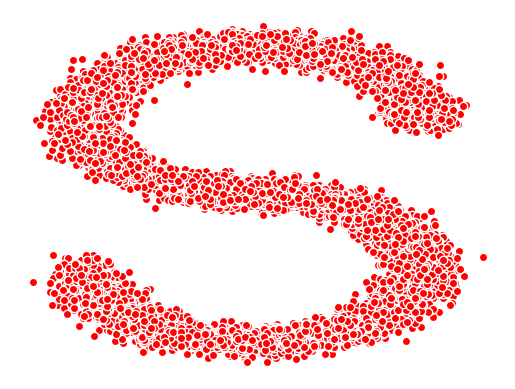

In [10]:
s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0
print("shape of moons: ", np.shape(s_curve))

data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color="red", edgecolor="white")
ax.axis("off")

dataset = torch.Tensor(s_curve).float()

### Hyperparameter

In [11]:
num_steps = 100 

betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

# calculate alpha, alpha_prod, alpha_prod_previous, alpha_bar_sqrt
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)  # p means previous
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == \
    alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == \
    one_minus_alphas_bar_sqrt.shape
print("All hyperparameters are in the shape of ", betas.shape)

All hyperparameters are in the shape of  torch.Size([100])


### Determine the sampling value during diffusion process

In [12]:
def q_x(x_0, t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)

### Display the noisy data after 100 diffusion steps 

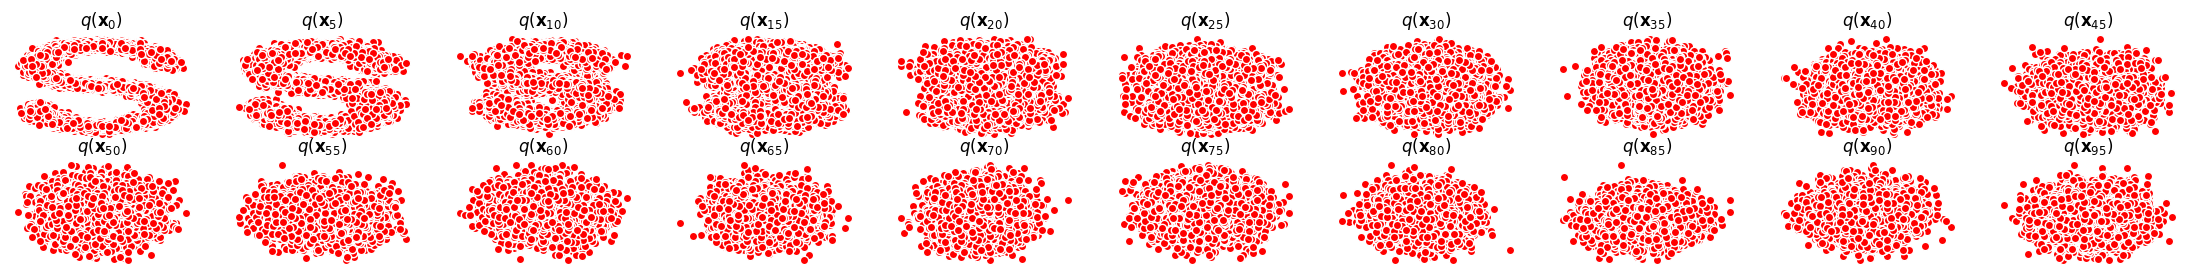

In [13]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc("text", color="blue")

for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i * num_steps // num_shows]))
    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color="red", edgecolor="white")
    axs[j, k].set_axis_off()
    axs[j, k].set_title("$q(\mathbf{x}_{" + str(i * num_steps // num_shows) + "})$")

### Model

In [14]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super().__init__()
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2)
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units)
            ]
        )
        
    def forward(self, x_0, t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)
            
        return self.linears[-1](x)

### Loss

In [15]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    
    # non-repeated t for efficiency
    t = torch.randint(0, n_steps, size=(batch_size//2, ))
    t = torch.cat([t, n_steps-1-t], dim=0)
    t = t.unsqueeze(-1)
    
    # coefficient for x_0
    a = alphas_bar_sqrt[t]
    # coefficient for epsilon
    aml = one_minus_alphas_bar_sqrt[t]
    e = torch.randn_like(x_0)
    
    x = a * x_0 + aml * e
    output = model(x, t.squeeze(-1))
    
    return (e - output).square().mean()

### Sampling process

In [16]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_thetas = model(x, t)
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_thetas))
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)

### Training

Training ...
tensor(0.6488, grad_fn=<MeanBackward0>)
tensor(0.1854, grad_fn=<MeanBackward0>)
tensor(0.1844, grad_fn=<MeanBackward0>)
tensor(0.1819, grad_fn=<MeanBackward0>)
tensor(0.4205, grad_fn=<MeanBackward0>)
tensor(0.3512, grad_fn=<MeanBackward0>)
tensor(0.3550, grad_fn=<MeanBackward0>)
tensor(0.2414, grad_fn=<MeanBackward0>)
tensor(0.2613, grad_fn=<MeanBackward0>)
tensor(0.4583, grad_fn=<MeanBackward0>)
tensor(0.2225, grad_fn=<MeanBackward0>)
tensor(0.3211, grad_fn=<MeanBackward0>)
tensor(0.3582, grad_fn=<MeanBackward0>)
tensor(0.2676, grad_fn=<MeanBackward0>)
tensor(0.4971, grad_fn=<MeanBackward0>)
tensor(0.2102, grad_fn=<MeanBackward0>)
tensor(0.5069, grad_fn=<MeanBackward0>)
tensor(0.1691, grad_fn=<MeanBackward0>)
tensor(0.2963, grad_fn=<MeanBackward0>)
tensor(0.1400, grad_fn=<MeanBackward0>)
tensor(0.2262, grad_fn=<MeanBackward0>)
tensor(0.3524, grad_fn=<MeanBackward0>)
tensor(0.1847, grad_fn=<MeanBackward0>)
tensor(0.5142, grad_fn=<MeanBackward0>)
tensor(0.4391, grad_fn=<Mea

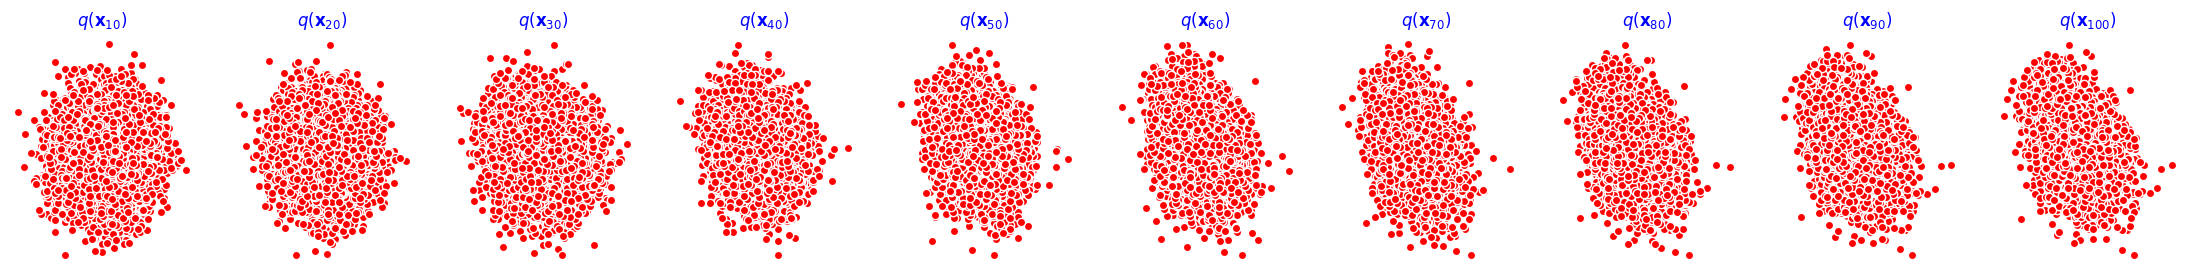

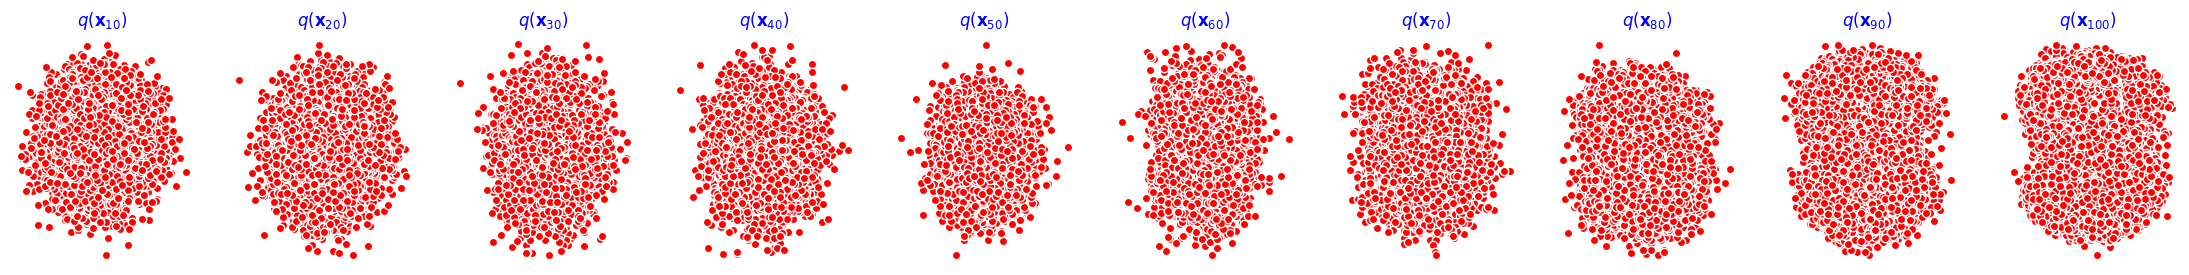

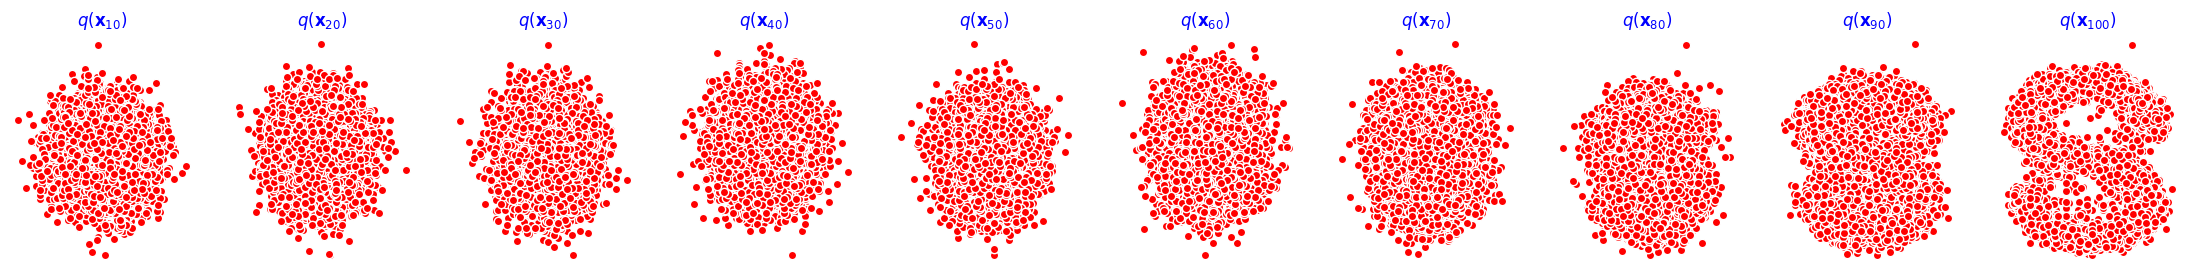

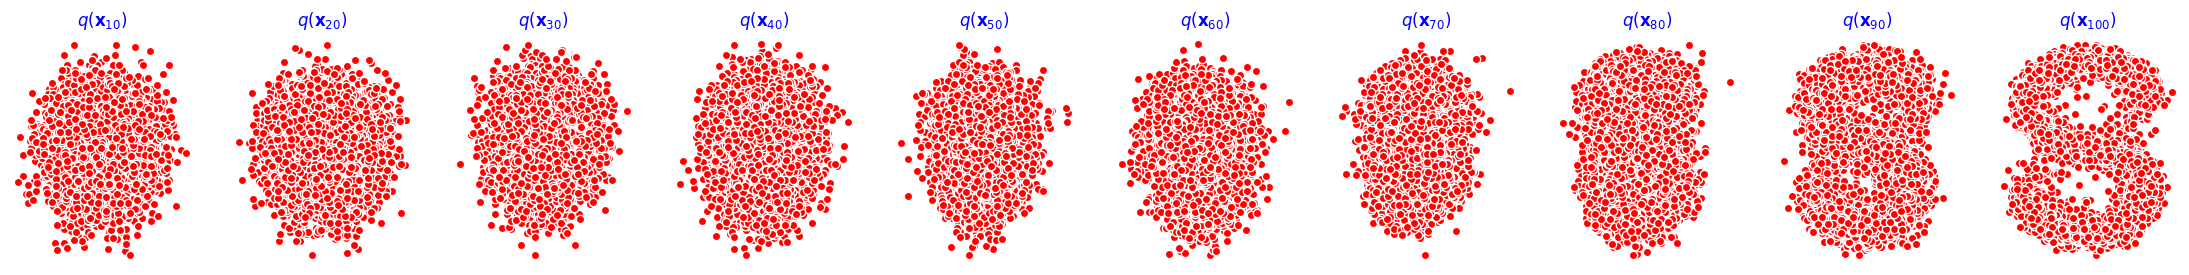

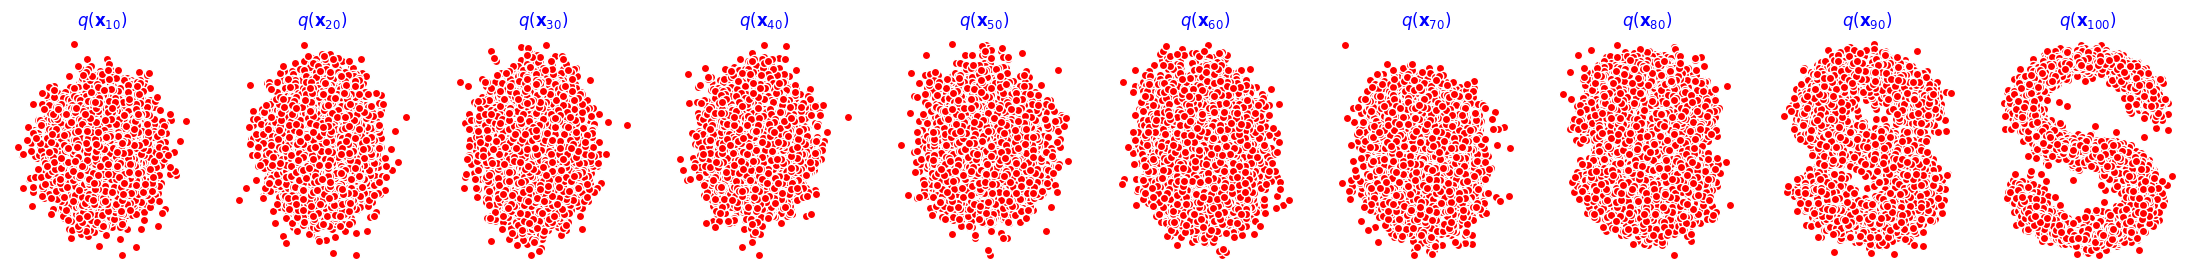

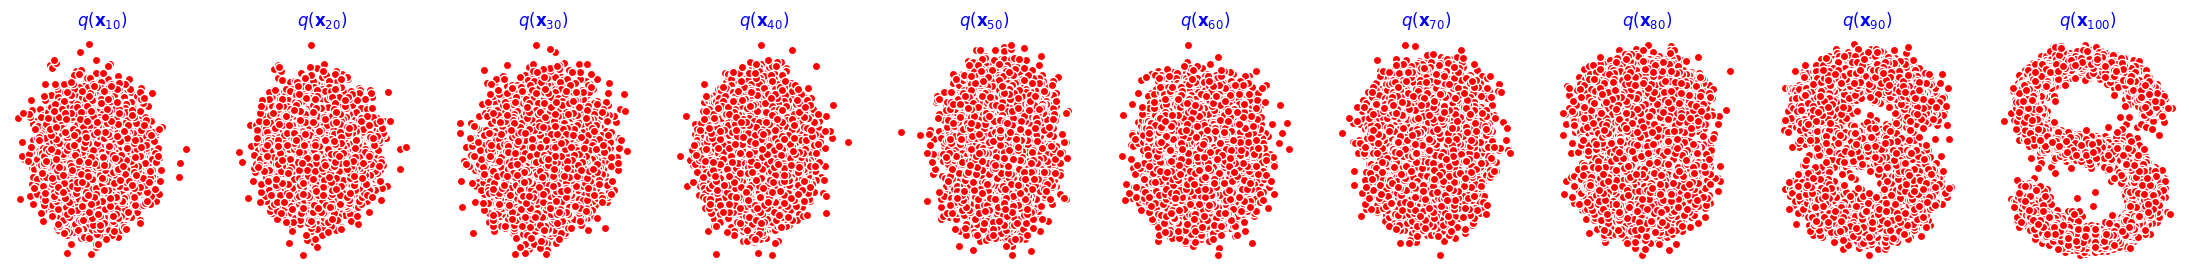

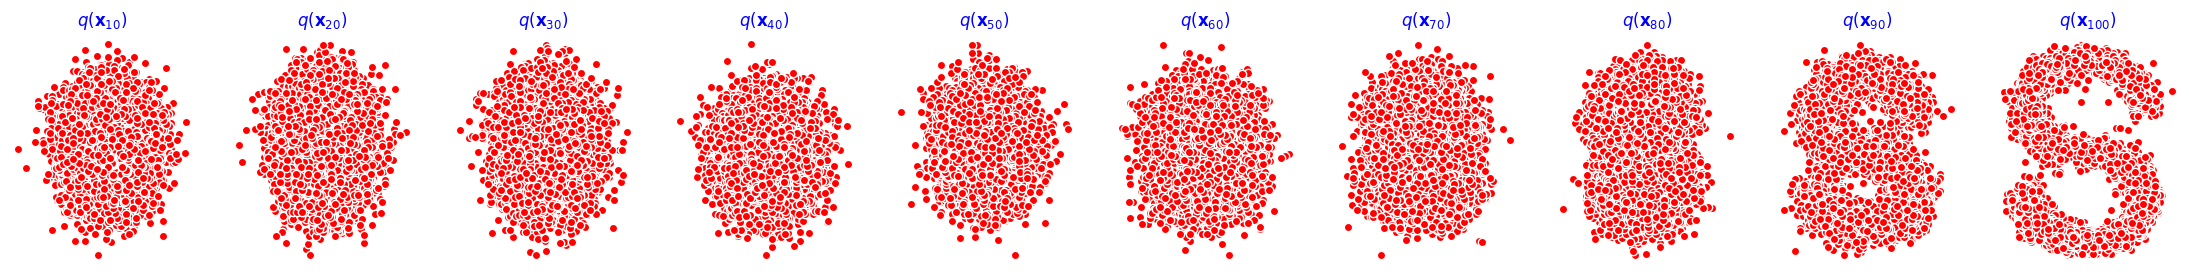

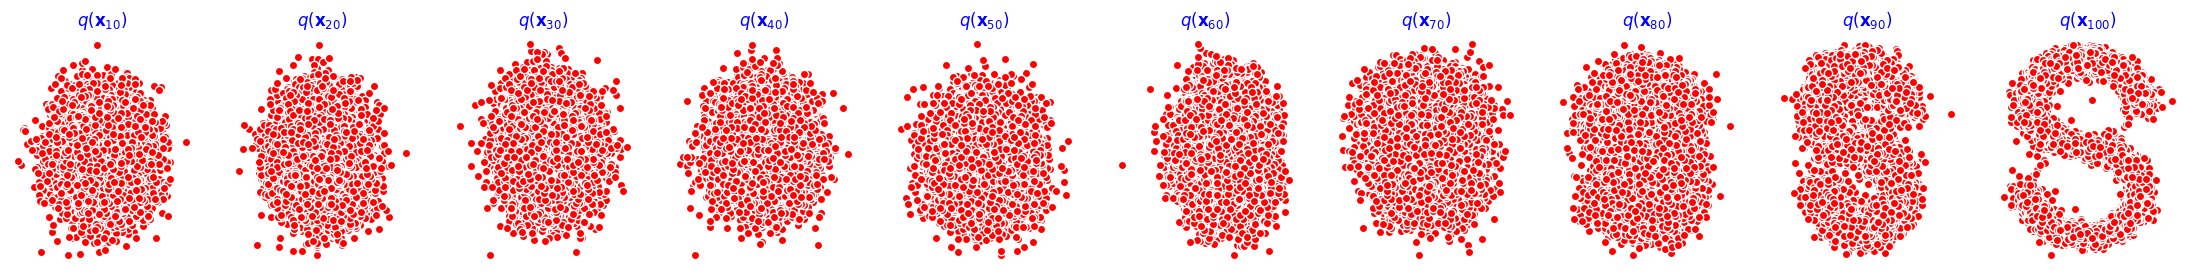

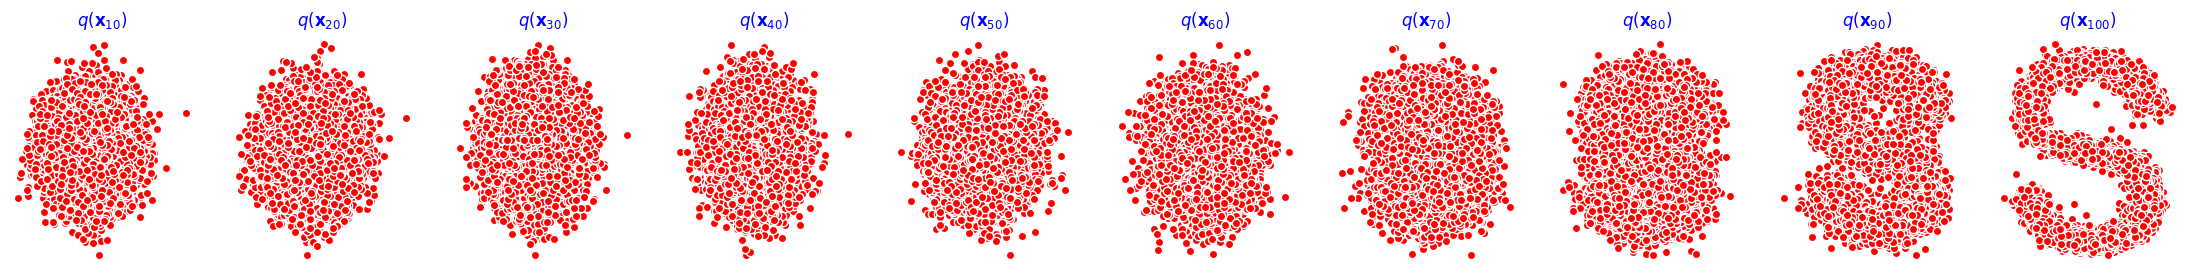

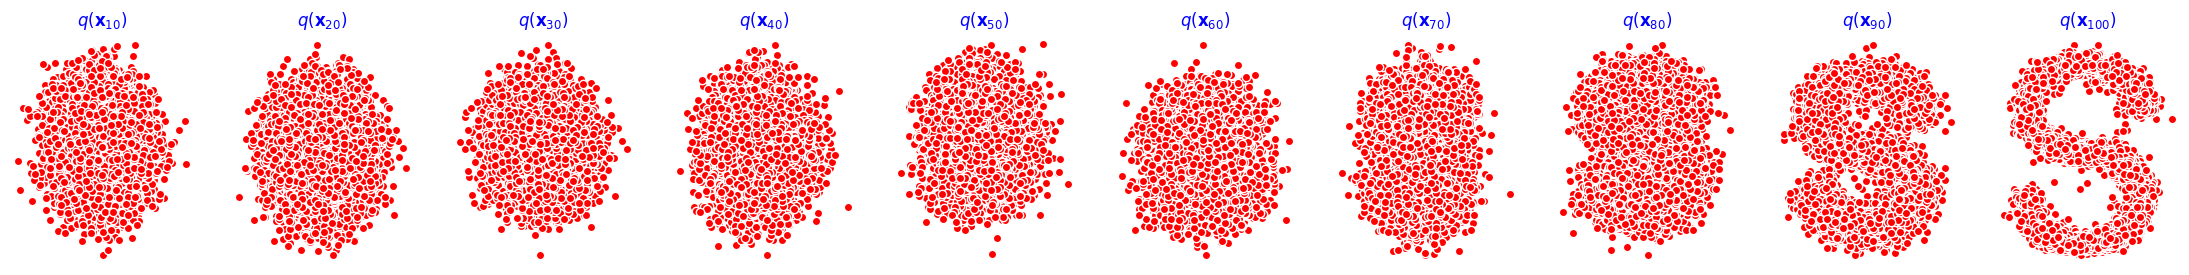

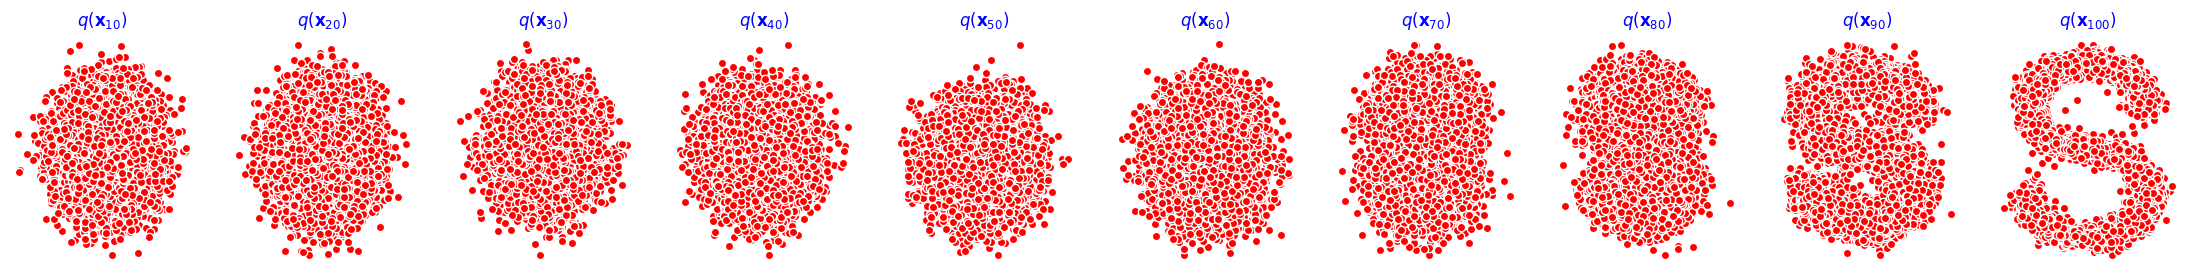

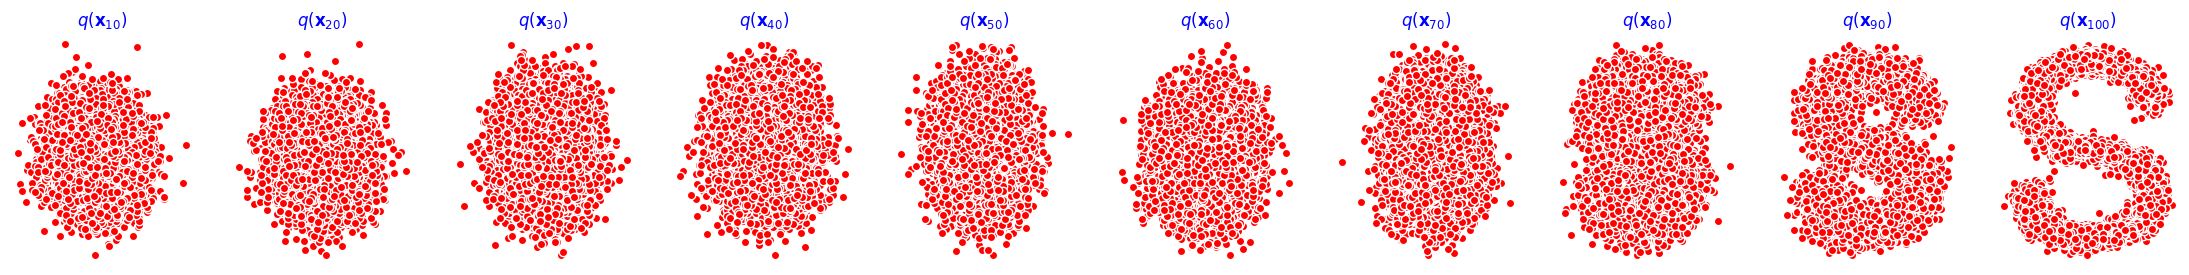

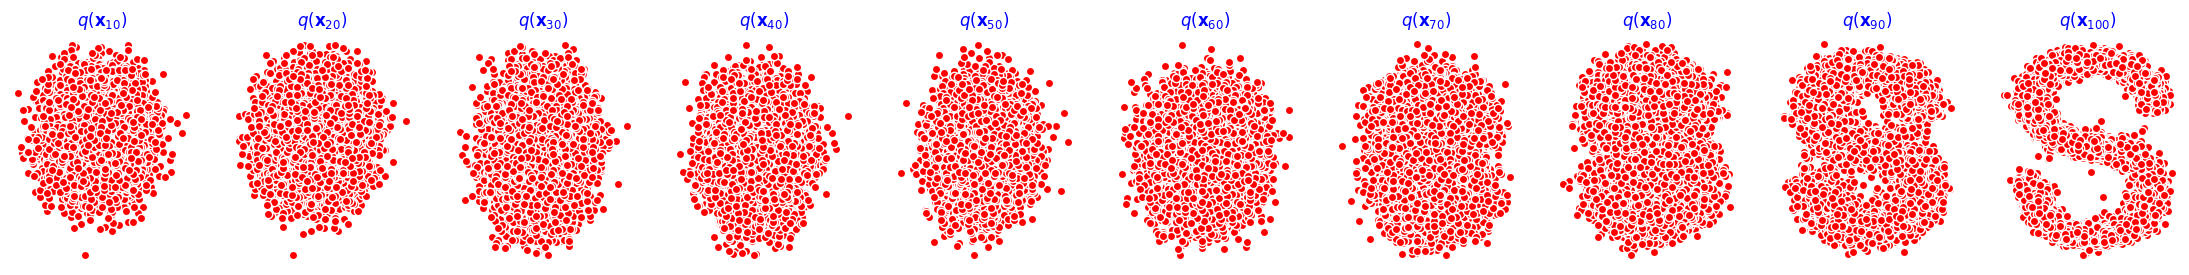

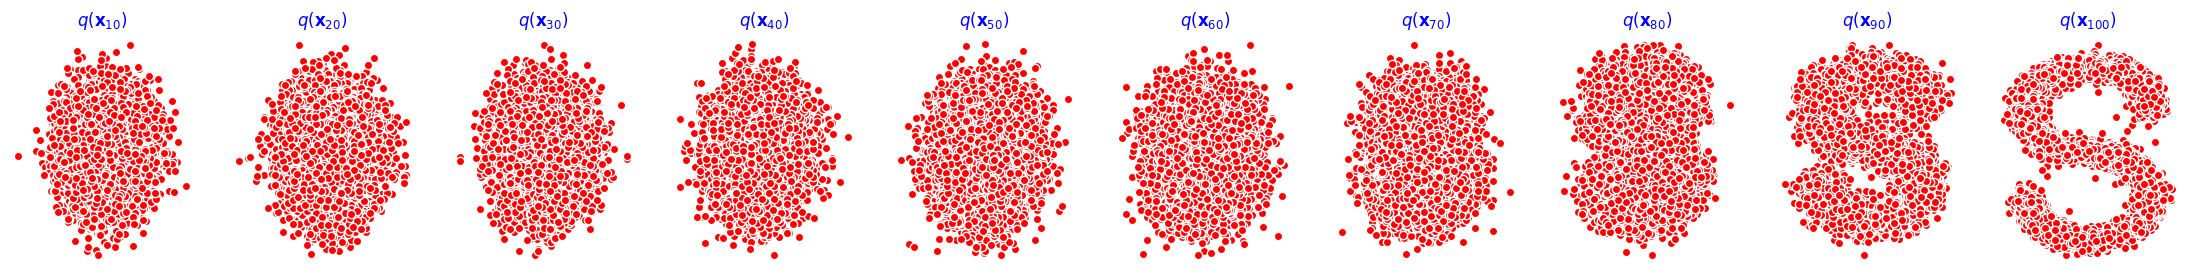

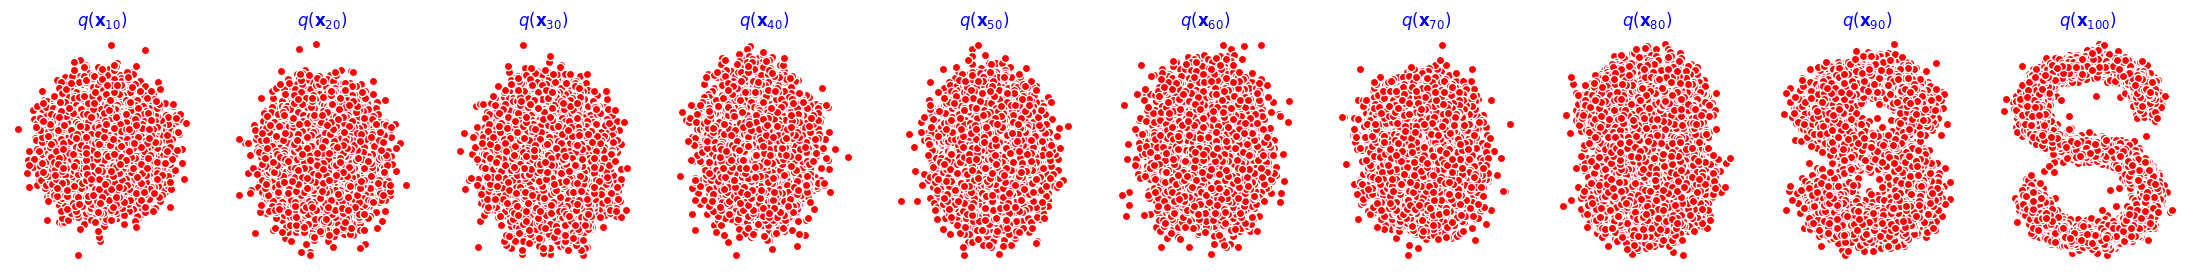

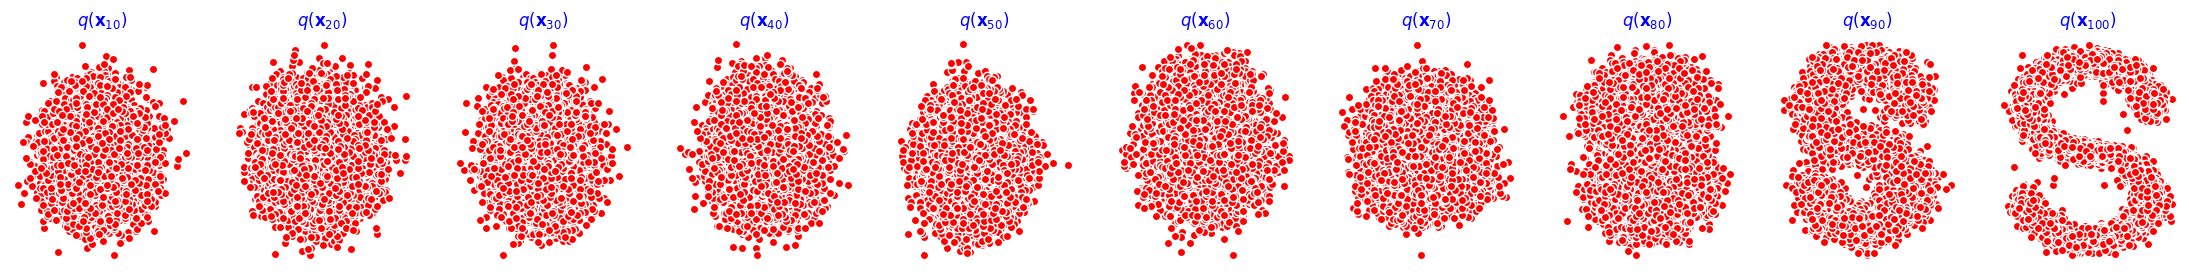

In [17]:
seed = 1234

class EMA():
    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}
        
    def register(self, name, val):
        self.shadow[name] = val.clone()
        
    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1. - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average
    
print("Training ...")

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epochs = 8000
plt.rc("text", color="blue")

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epochs):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        
    if (t % 100 == 0):
        print(loss)
        
    if (t % 500 == 0):
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color="red", edgecolor="white")
            axs[i-1].set_axis_off()
            axs[i-1].set_title("$q(\mathbf{x}_{" + str(i*10) + "})$")